In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br

from pycbc import conversions as conv
from  pycbc.filter.matchedfilter import optimized_match

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter

from pycbc import types, fft, waveform

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


# PYCBC Waveform and Plotting Functions

In [17]:
## GENERATE PYCBC WAVEFORMS
def get_pycbc_waveforms_fd(net_true, net_ap):
    delta_f = net_ap.f[1] - net_ap.f[0]

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_ap.f, net_ap.detectors[0].f, assume_unique=True)

    hp1_fs = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
    hc1_fs = FrequencySeries(net_true.hfc[freq_mask], delta_f=delta_f)

    hp2_fs = FrequencySeries(net_ap.hfp[freq_mask], delta_f=delta_f)
    hc2_fs = FrequencySeries(net_ap.hfc[freq_mask], delta_f=delta_f)

    # Combine frequency-domain waveforms
    h1_fs = hp1_fs+ 1.j*hc1_fs
    h2_fs = hp2_fs+ 1.j*hc2_fs

    return h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs


# FFT it to the time-domain
def get_pycbc_waveforms_td(net_true, net_ap):
    delta_t=1.0/4096
    delta_f = net_ap.f[1] - net_ap.f[0]

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_ap.f, net_ap.detectors[0].f, assume_unique=True)

    hp1_fs = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
    hc1_fs = FrequencySeries(net_true.hfc[freq_mask], delta_f=delta_f)

    hp2_fs = FrequencySeries(net_ap.hfp[freq_mask], delta_f=delta_f)
    hc2_fs = FrequencySeries(net_ap.hfc[freq_mask], delta_f=delta_f)

    tlen = int(1.0 / delta_t / hp1_fs.delta_f)
    hp1_fs.resize(tlen/2 + 1)
    hp1_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hp1_fs, hp1_ts)

    tlen = int(1.0 / delta_t / hc1_fs.delta_f)
    hc1_fs.resize(tlen/2 + 1)
    hc1_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hc1_fs, hc1_ts)


    tlen = int(1.0 / delta_t / hp2_fs.delta_f)
    hp2_fs.resize(tlen/2 + 1)
    hp2_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hp2_fs, hp2_ts)

    tlen = int(1.0 / delta_t / hc2_fs.delta_f)
    hc2_fs.resize(tlen/2 + 1)
    hc2_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hc2_fs, hp2_ts)

    h1_ts = hp1_ts+ 1.j*hc1_ts
    h2_ts = hp2_ts+ 1.j*hc2_ts

    return h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts

In [9]:
def plot_f_series(h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs):    
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8, 8))

    axes[0].plot(hp1_fs.sample_frequencies, h1_fs, label=approx1)
    axes[0].plot(hp2_fs.sample_frequencies, h2_fs, label=approx2)
    axes[0].set_ylabel("$h (f)$")
    axes[0].legend()


    axes[1].plot(hp1_fs.sample_frequencies, np.abs(h1_fs), label=approx1)
    axes[1].plot(hp2_fs.sample_frequencies, np.abs(h2_fs), label=approx2)
    axes[1].set_ylabel("Amplitude")
    axes[1].legend()

    axes[2].plot(hp1_fs.sample_frequencies, np.unwrap(np.angle(h1_fs)), label=approx1)
    axes[2].plot(hp2_fs.sample_frequencies, np.unwrap(np.angle(h2_fs)), label=approx2)
    axes[2].set_ylabel("Phase")
    axes[2].legend()
    axes[2].set_ylim(0, 150)

    plt.xlabel("$f$")
    plt.xlim(0, 20)
    plt.show()

In [10]:
def plot_t_series(h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts):

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8, 8))

    axes[0].plot(hp1_ts.sample_times, hp1_ts, label=approx1)
    axes[0].plot(hp2_ts.sample_times, hp2_ts, label=approx2)

    axes[0].set_ylabel("$\\tilde{h}(t)$")
    axes[0].legend()
    axes[0].set_xlim(5, 17)

    amp1 = waveform.utils.amplitude_from_polarizations(hp1_ts, hc1_ts)
    amp2 = waveform.utils.amplitude_from_polarizations(hp2_ts, hc2_ts)
    axes[1].plot(hp1_ts.sample_times, amp1, label=approx1)
    axes[1].plot(hp2_ts.sample_times, amp2, label=approx2)
    axes[2].set_ylabel("Amplitude")

    phase1 = waveform.utils.phase_from_polarizations(hp1_ts, hc1_ts)
    phase2 = waveform.utils.phase_from_polarizations(hp2_ts, hc2_ts)
    axes[2].plot(hp1_ts.sample_times, phase1, label=approx1)
    axes[2].plot(hp2_ts.sample_times, phase2, label=approx2)
    axes[2].set_ylabel("Phase")
    axes[2].set_xlabel("Time (s)")
    axes[2].legend()
    axes[2].set_xlim(5, 17)

    plt.show()

# No Phic or tc opt

In [70]:
# # Detector frame
# m1 = 85#M_sol
# m2 = 66 #M_sol
# DL = Planck18.luminosity_distance(0.82).value
# q = m2/m1


# Mc = conv.mchirp_from_mass1_mass2(m1, m2)
# eta = conv.eta_from_mass1_mass2(m1, m2)

# # set the injection parameters
# inj_params = {
#     'Mc':    Mc,
#     'eta':   eta,
#     'chi1x': 0,
#     'chi2x': 0,
#     'chi1y': 0,
#     'chi2y': 0,
#     'chi1z': 0.,
#     'chi2z': 0.,
#     'DL':    DL,
#     'tc':    0.,
#     'phic':  0.,
#     'iota':  np.pi/3,
#     'ra':    np.pi/3,
#     'dec':   np.pi/3,
#     'psi':   np.pi/3,
#     'gmst0': 0.,
#     'hybr':  0.
#     }

inj_params = {
    'Mc':    39.097781,
    'eta':   0.247392,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': -0.006386,
    'chi2z': 0.027479,
    'DL':    1884.305356,
    'tc':    0.,
    'phic':  0.,
    'iota':  0.389333,
    'ra':    0.167403,
    'dec':   -0.352156,
    'psi':   4.411578,
    'gmst0': 0.,
    'hybr':  0.
}

net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)
net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

2023-10-12 16:34:11,910 - Network - INFO : Polarizations calculated.
2023-10-12 16:34:11,912 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-12 16:34:11,921 - Network - INFO : Polarizations calculated.
2023-10-12 16:34:12,856 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-12 16:34:12,902 - Network - INFO : PSDs loaded.
2023-10-12 16:34:12,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-12 16:34:12,932 - Network - INFO : Detector responses calculated.
2023-10-12 16:34:12,933 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-12 16:34:12,933 - Network - INFO :    CE-40_C
2023-10-12 16:34:13,536 - Network - INFO :    CE-20_S
2023-10-12 16:34:14,124 - Network - INFO :    ET_ET1
2023-10-12 16:34:14,717 - Network - INFO :    ET_ET2
2023-10-12 16:34:15,312 - Network - INFO :    ET_ET3
2023-10-12 16:34:15,884 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-12 1

In [71]:
h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs = get_pycbc_waveforms_fd(net_true, net_ap)
fd_waveforms = [h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs]

h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts = get_pycbc_waveforms_td(net_true, net_ap)
td_waveforms = [h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts]

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


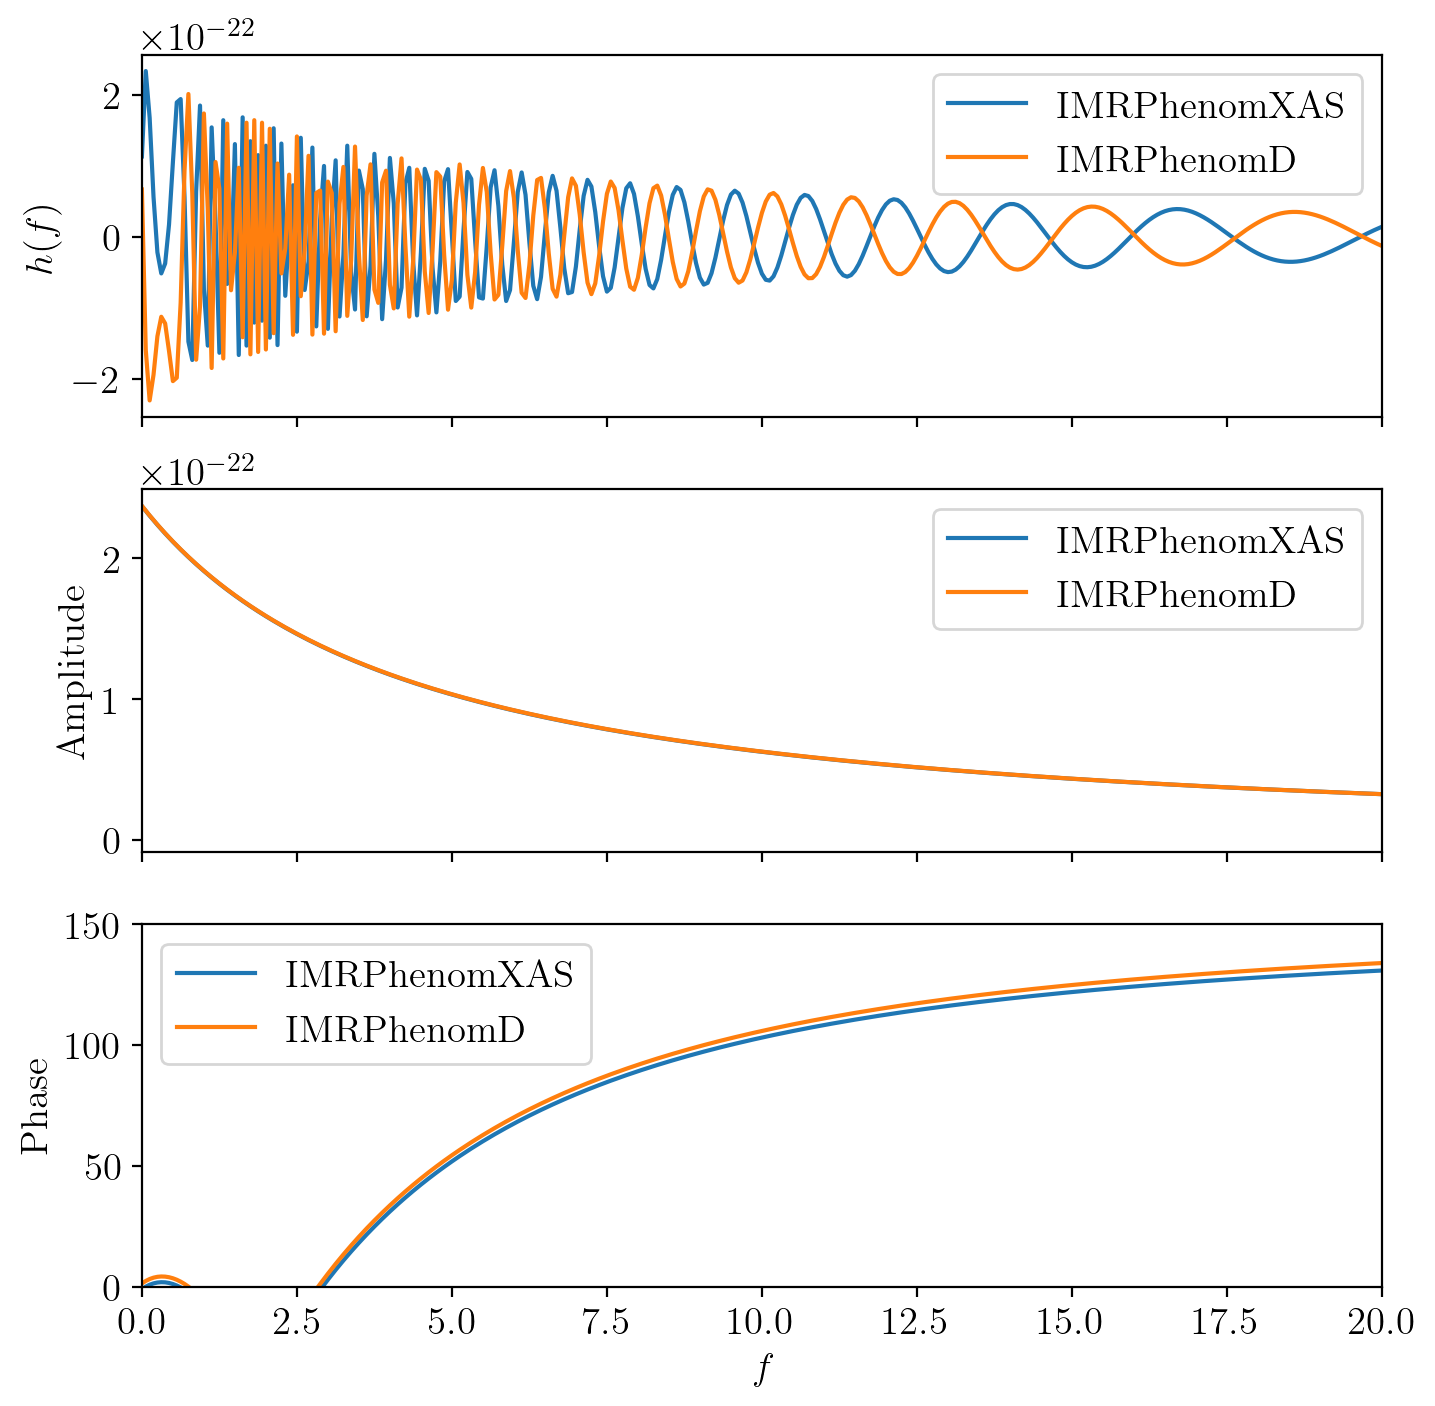

In [72]:
plot_f_series(*fd_waveforms)

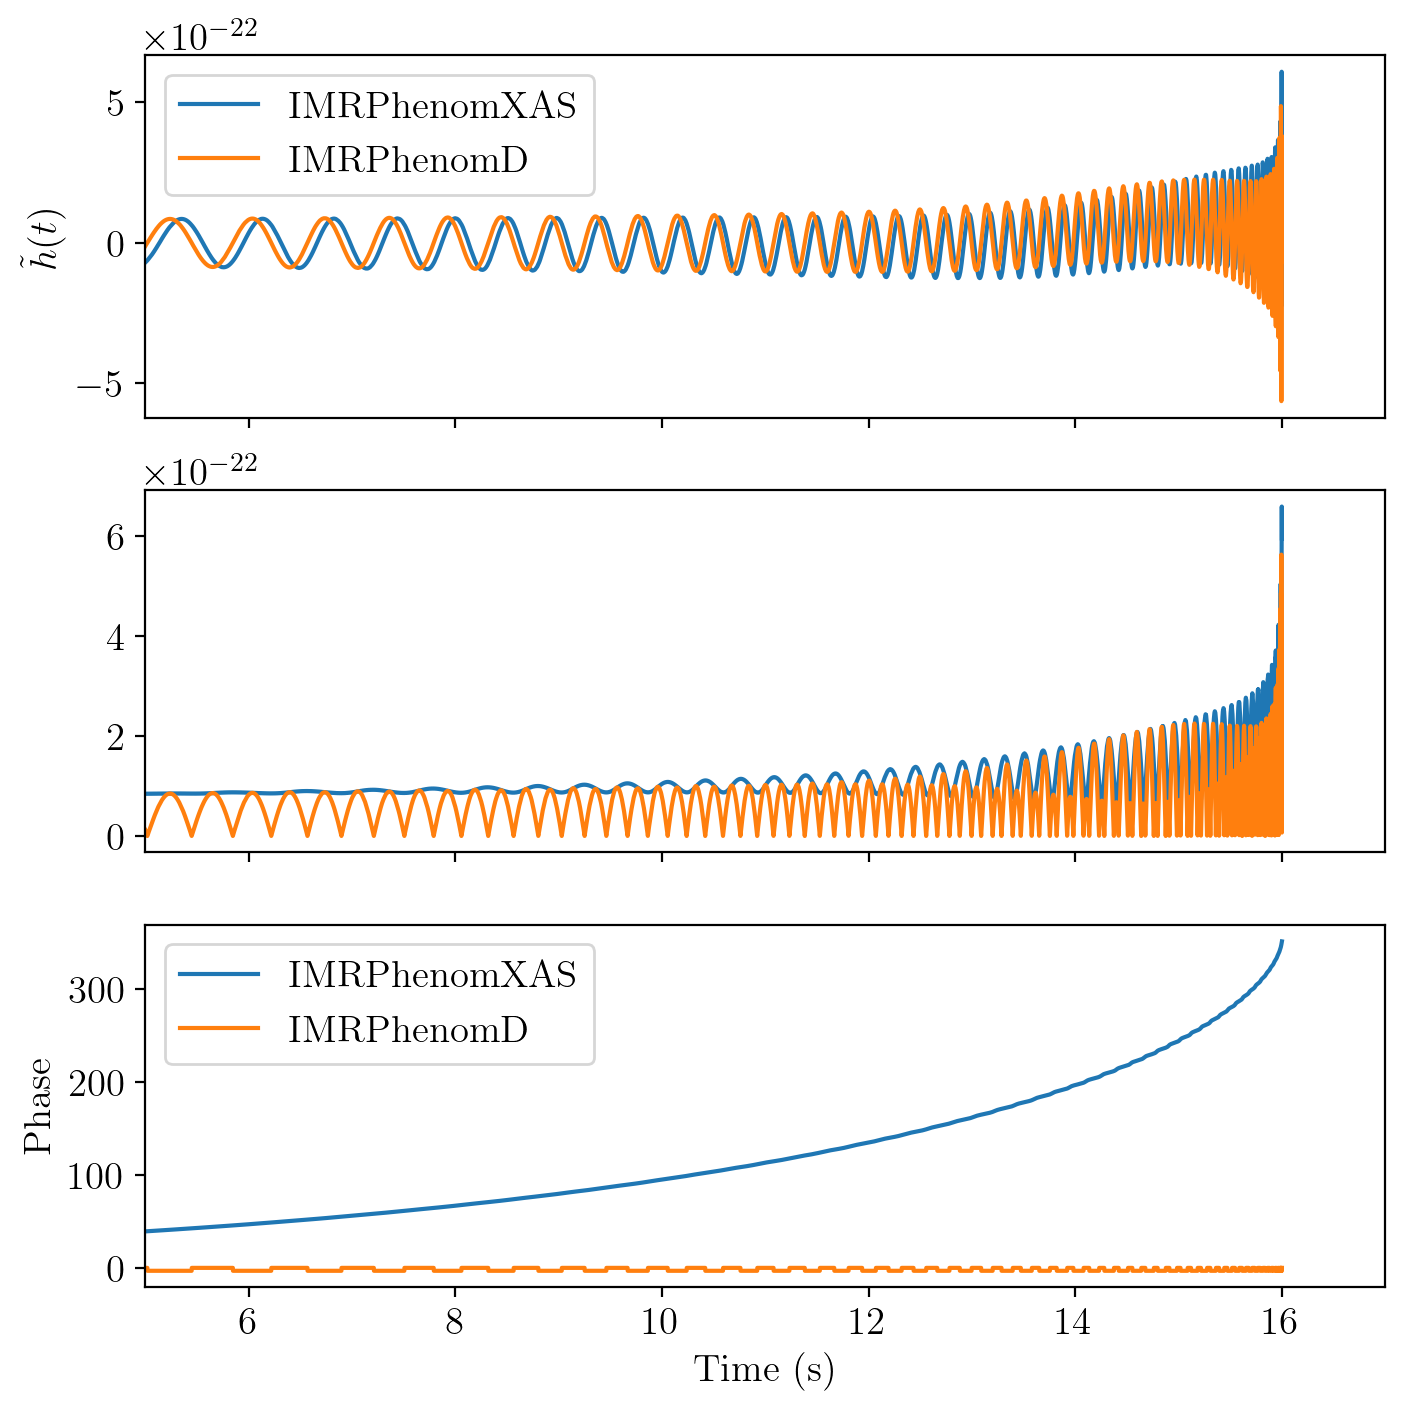

In [73]:
plot_t_series(*td_waveforms)

## Biases

Biases: [0.6963524024228036, 0.29450921385291906, -38.038085512693215, 47.506430593286495, 835.307092955336, 0.25475046801309986, 12.718465392763846, 3.522557745074664, -0.012443195343885272, 0.005729557821757325, 2.3388571666324083]
Errors: [2.72458210e-03 1.62490970e-03 1.57268450e-01 1.93419620e-01
 1.02708870e+02 1.04259071e-03 7.27048159e-01 1.35238722e-01
 4.76539048e-04 4.04148130e-04 3.63355696e-01]


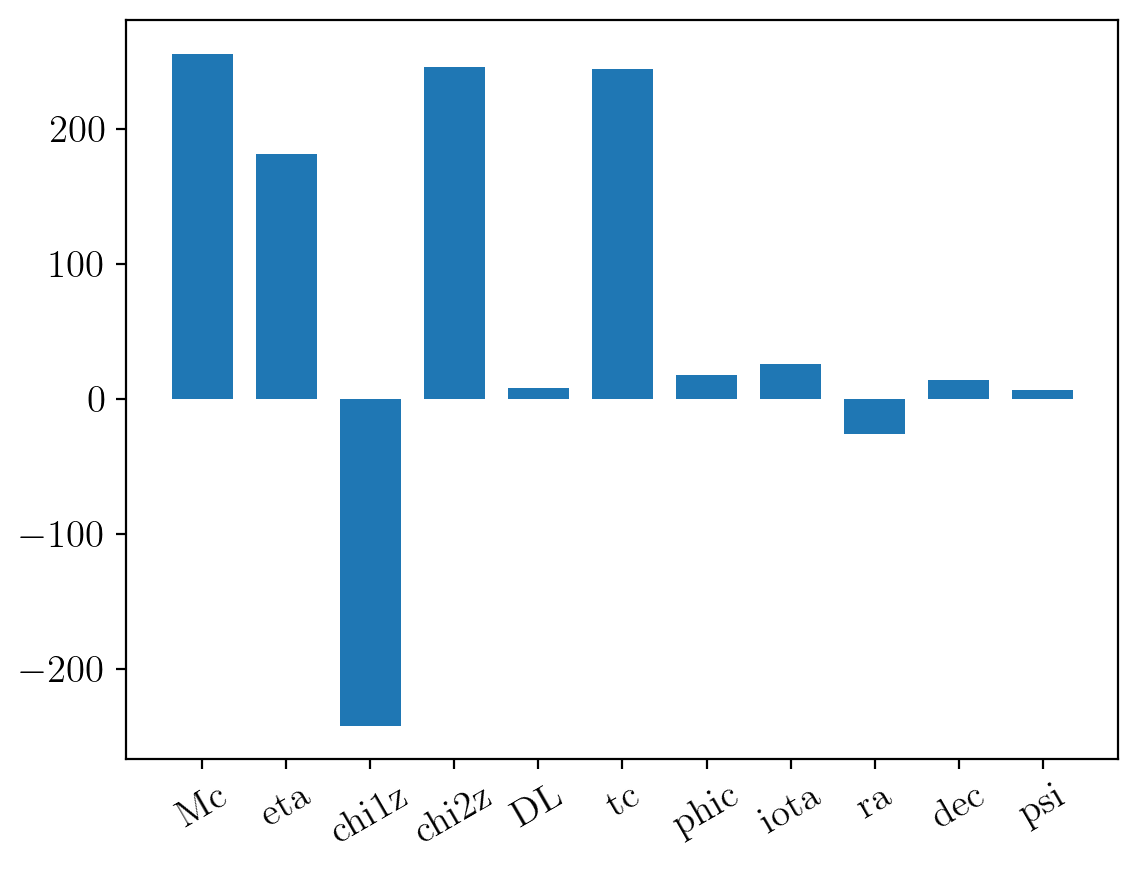

In [83]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))

for i, param in enumerate(net_ap.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]

print("Biases:", bias_no_opt)
print("Errors:", err_no_opt)

x = np.linspace(0, len(bias_no_opt), len(bias_no_opt))
plt.bar(x, bias_no_opt/err_no_opt)
plt.xticks(x, net_ap.deriv_variables, rotation=30)
plt.show()

# Phic and tc optimized

In [84]:
# match, index, phi = matchedfilter.match(h1_fs, h2_fs, return_phase=True)
# print(match, index, phi)

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
print(match, index, phi)

tc = h1_ts.sample_times[int(index)]
phic = phi

0.9999246506891623 6073.814589764844 -2.3669962579247805


In [85]:
# set the injection parameters
inj_params_opt = inj_params
inj_params_opt['phic'] = -phic


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt = gwnet.get_hybrid_network_response(inj_params=inj_params_opt, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

2023-10-12 16:41:08,041 - Network - INFO : Polarizations calculated.
2023-10-12 16:41:08,042 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-12 16:41:08,049 - Network - INFO : Polarizations calculated.
2023-10-12 16:41:08,967 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-12 16:41:09,014 - Network - INFO : PSDs loaded.
2023-10-12 16:41:09,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-12 16:41:09,043 - Network - INFO : Detector responses calculated.
2023-10-12 16:41:09,044 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-12 16:41:09,045 - Network - INFO :    CE-40_C
2023-10-12 16:41:09,643 - Network - INFO :    CE-20_S
2023-10-12 16:41:10,483 - Network - INFO :    ET_ET1
2023-10-12 16:41:11,322 - Network - INFO :    ET_ET2
2023-10-12 16:41:12,207 - Network - INFO :    ET_ET3
2023-10-12 16:41:13,180 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-12 1

In [86]:
h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs = get_pycbc_waveforms_fd(net_true, net_ap_opt)
fd_waveforms_opt = [h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs]

h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts = get_pycbc_waveforms_td(net_true, net_ap_opt)
td_waveforms_opt = [h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts]

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


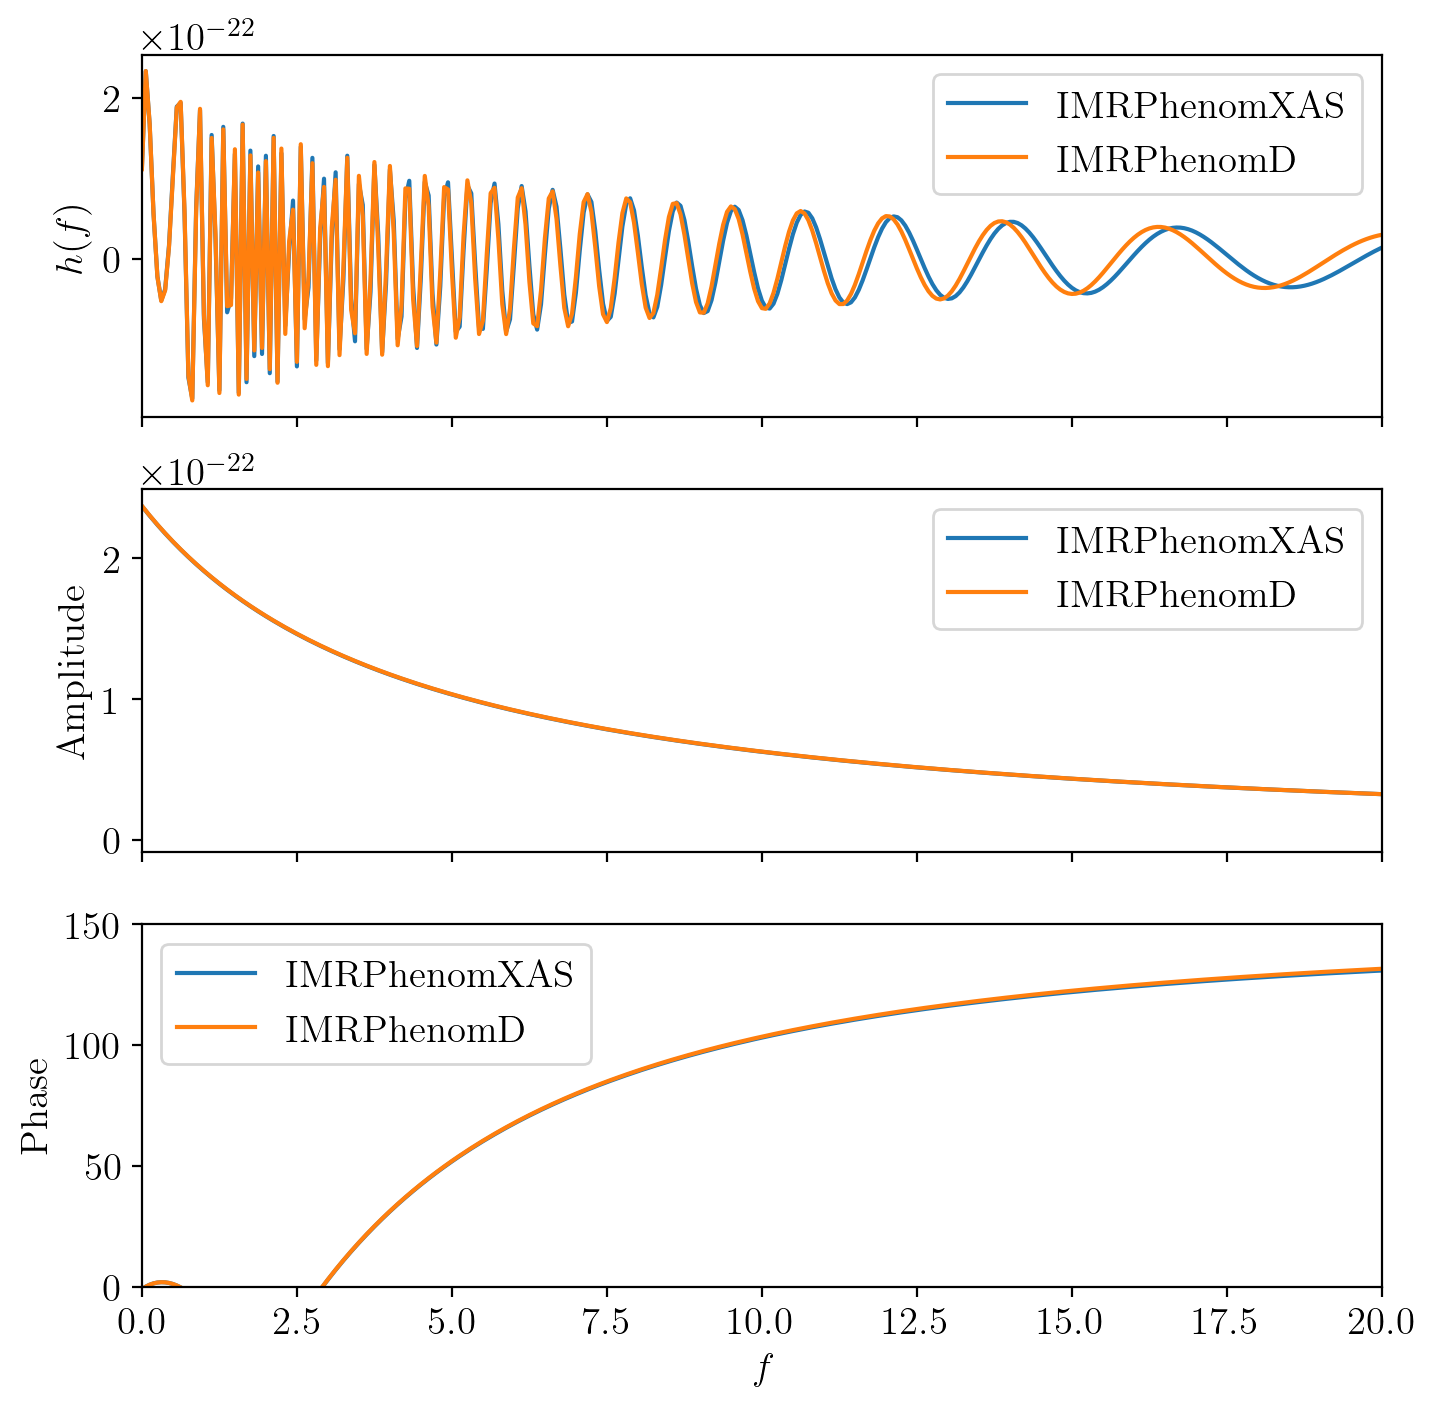

In [87]:
plot_f_series(*fd_waveforms_opt)

In [88]:
# My own version of phase shift
amp2_new = np.abs(h2_fs)
phase2_new = np.unwrap(np.angle(h2_fs)) + phi
h2_fs_new =  amp2_new * np.exp(1.j * phase2_new)


plot_f_series(h1_fs, h2_fs_new)

TypeError: plot_f_series() missing 4 required positional arguments: 'hc1_fs', 'h2_fs', 'hp2_fs', and 'hc2_fs'

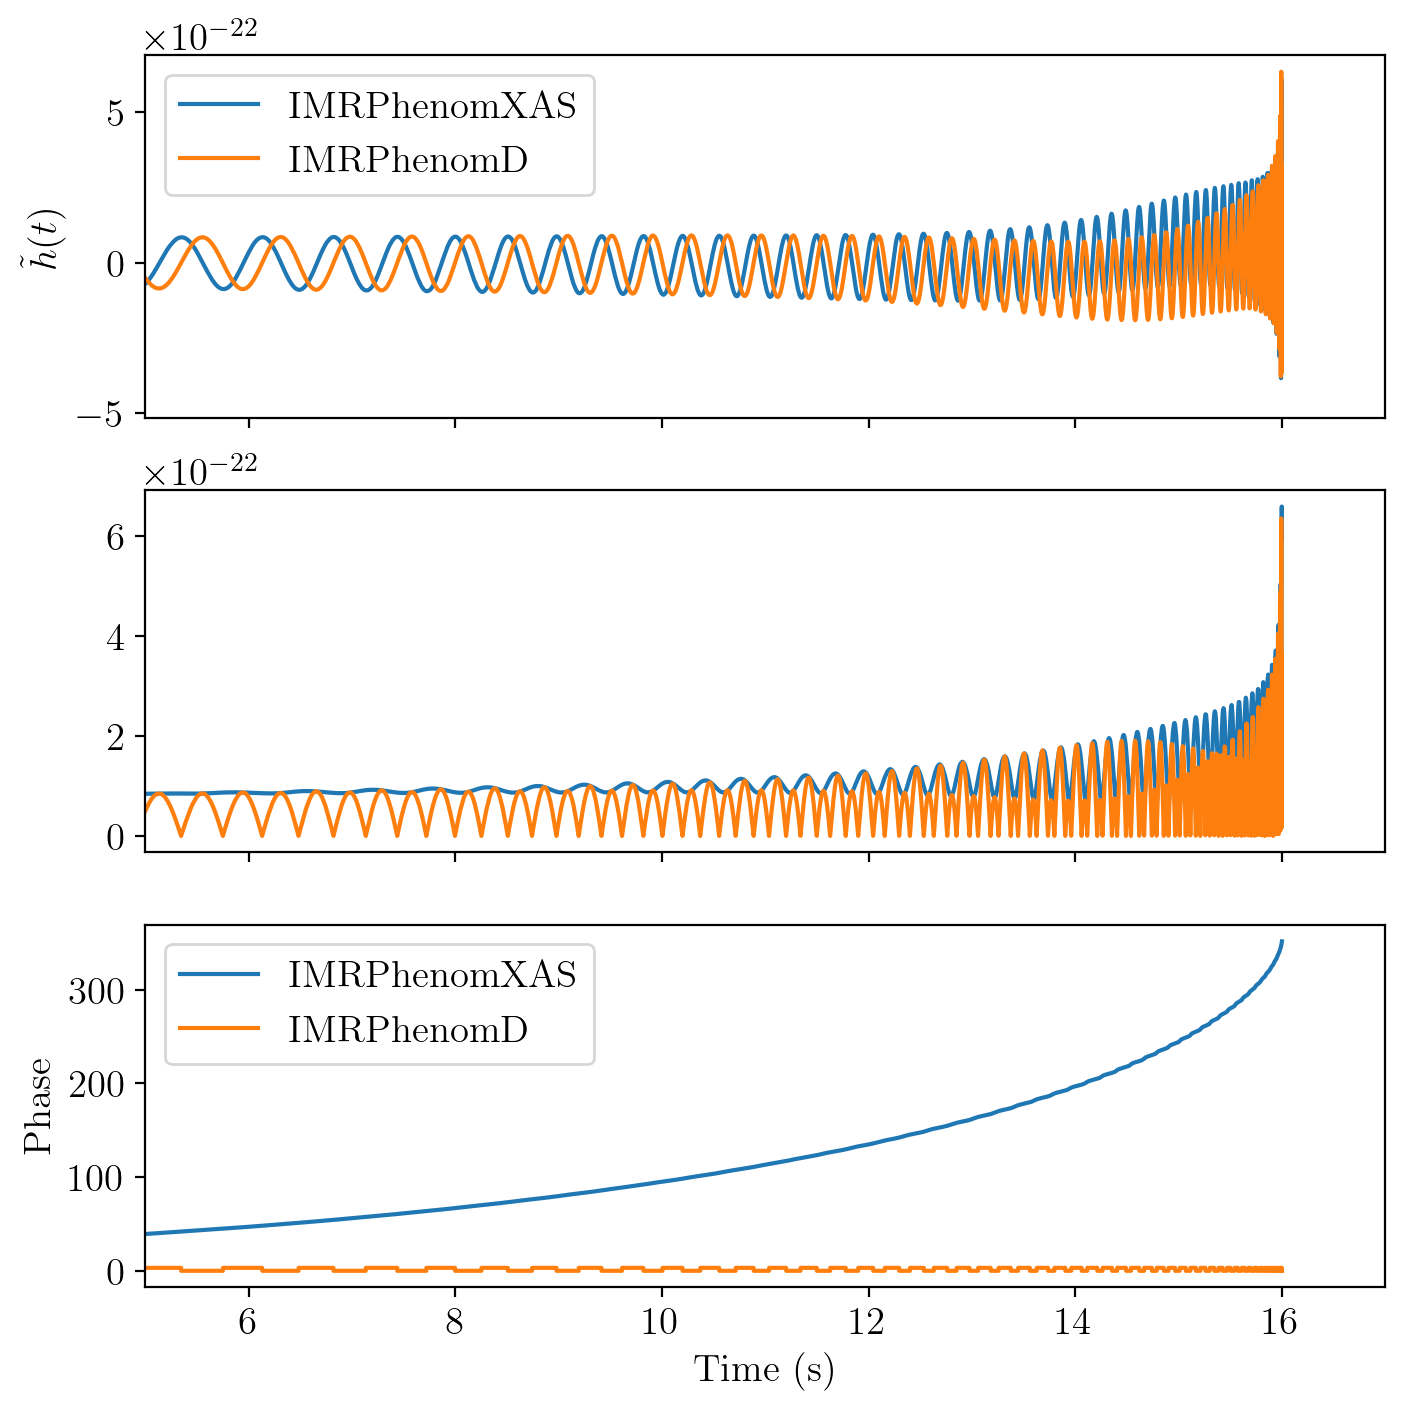

In [89]:
plot_t_series(*td_waveforms_opt)

## Biases

Biases: [0.6962845989649793, 0.29452263315089056, -38.039269806509765, 47.50862750287706, 834.3598644118756, 0.25475851563817287, 12.607076271927326, 3.523895795932731, -0.01241521200853768, 0.005727641617374601, 2.2842458327406803]
Errors: [2.72434857e-03 1.62492972e-03 1.57273024e-01 1.93425432e-01
 1.02742722e+02 1.04262296e-03 7.27302313e-01 1.35280490e-01
 4.76629939e-04 4.04078164e-04 3.63474578e-01]


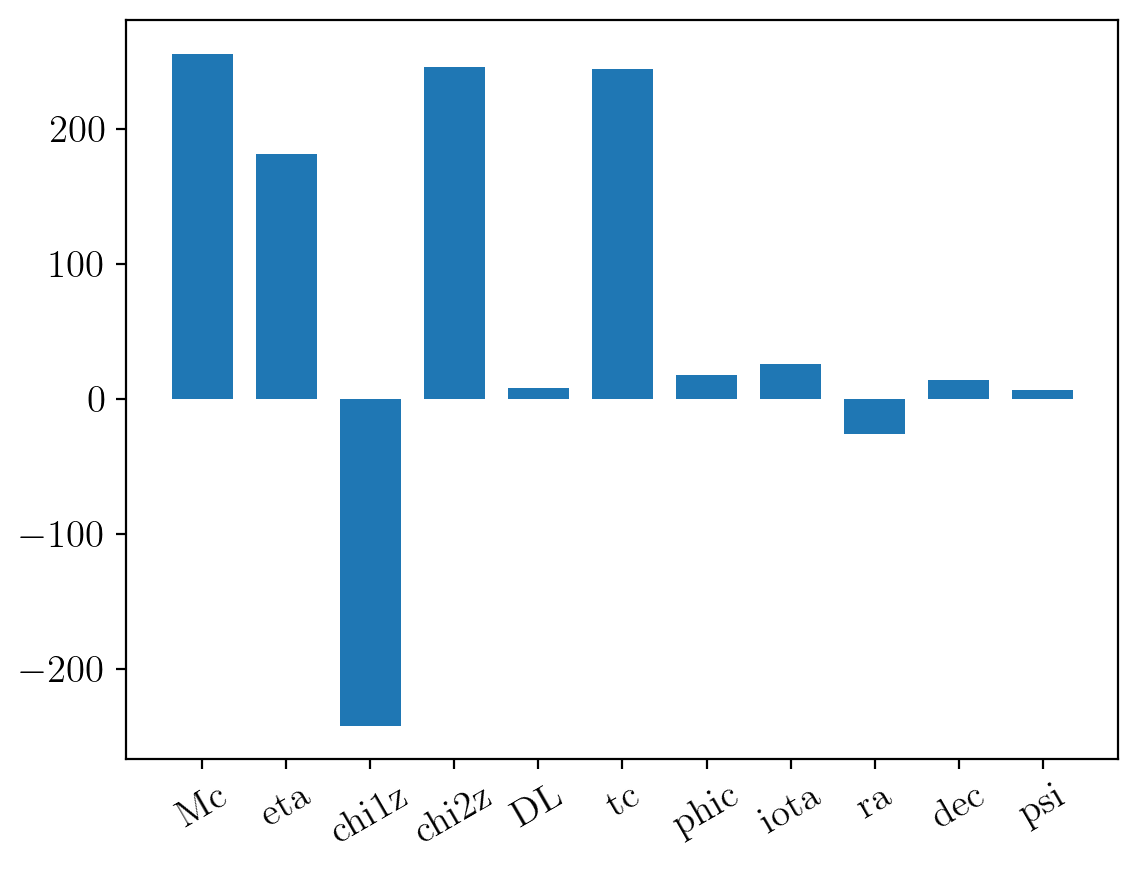

In [90]:
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
err_opt = np.zeros(len(bias_opt))

for i, param in enumerate(net_ap_opt.deriv_variables):
    err_opt[i] = net_ap_opt.errs[param]

print("Biases:", bias_opt)
print("Errors:", err_opt)

x = np.linspace(0, len(bias_opt), len(bias_opt))
plt.bar(x, bias_opt/err_opt)
plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)
plt.show()

# Bias Comparison

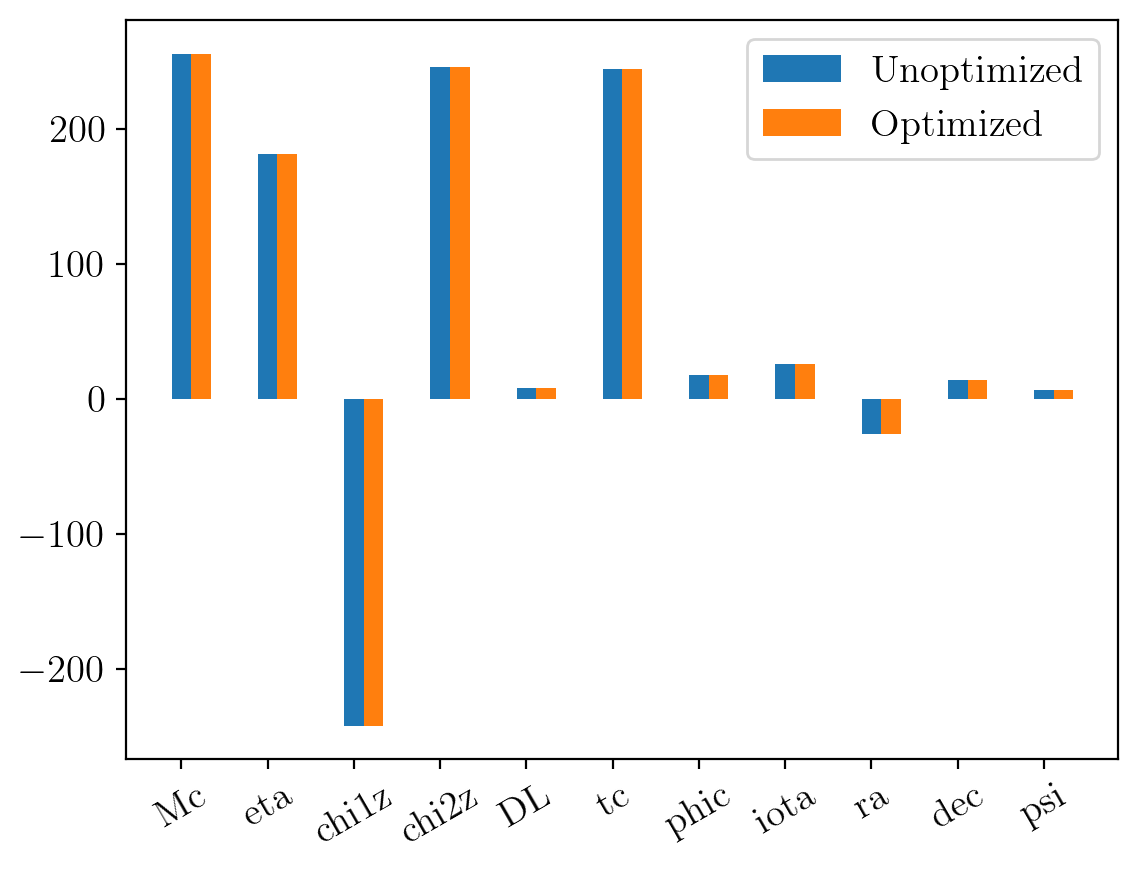

In [96]:
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
err_opt = np.zeros(len(bias_opt))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt[i] = net_ap_opt.errs[param]


x = np.linspace(0, len(bias_opt), len(bias_opt))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt/err_opt, width=width, label='Optimized')

plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [91]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    print(f"{param}, not: {bias_no_opt[i]/net_ap.errs[param]:.3f} sigma")
    print(f"{param}, opt: {bias_opt[i]/net_ap_opt.errs[param]:.3f} sigma")
    print()

Mc, not: 255.581 sigma
Mc, opt: 255.578 sigma

eta, not: 181.247 sigma
eta, opt: 181.253 sigma

chi1z, not: -241.867 sigma
chi1z, opt: -241.868 sigma

chi2z, not: 245.613 sigma
chi2z, opt: 245.617 sigma

DL, not: 8.133 sigma
DL, opt: 8.121 sigma

tc, not: 244.344 sigma
tc, opt: 244.344 sigma

phic, not: 17.493 sigma
phic, opt: 17.334 sigma

iota, not: 26.047 sigma
iota, opt: 26.049 sigma

ra, not: -26.112 sigma
ra, opt: -26.048 sigma

dec, not: 14.177 sigma
dec, opt: 14.175 sigma

psi, not: 6.437 sigma
psi, opt: 6.284 sigma



# Test over 10 random binaries